# Определение возраста покупателей

Требуется система компьютерного зрения для обработки фотографий покупателей. Фотофиксация поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной- модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Исследовательский анализ данных

Импортируем нужные нам библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.sample(10)

,file_name,real_age
5073,005073.jpg,22
7490,007512.jpg,25
381,000381.jpg,35
2811,002811.jpg,55
5598,005598.jpg,34
2303,002303.jpg,1
4249,004249.jpg,18
2169,002169.jpg,45
2103,002103.jpg,50
5361,005361.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Посмотрим на размер выборки

In [5]:
labels.shape

(7591, 2)

Постром график распределения возраста в выборке.

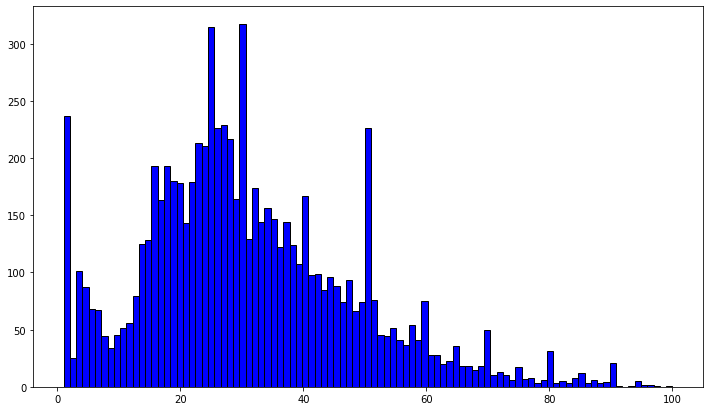

In [6]:
fig = plt.figure(figsize=(12, 7))
plt.hist(labels['real_age'], color='blue', edgecolor='black', bins=len(labels['real_age'].unique()))
plt.show()

Загрузим фотографии

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

Напечатаем на экране 12 фотографий с возрастом человека.

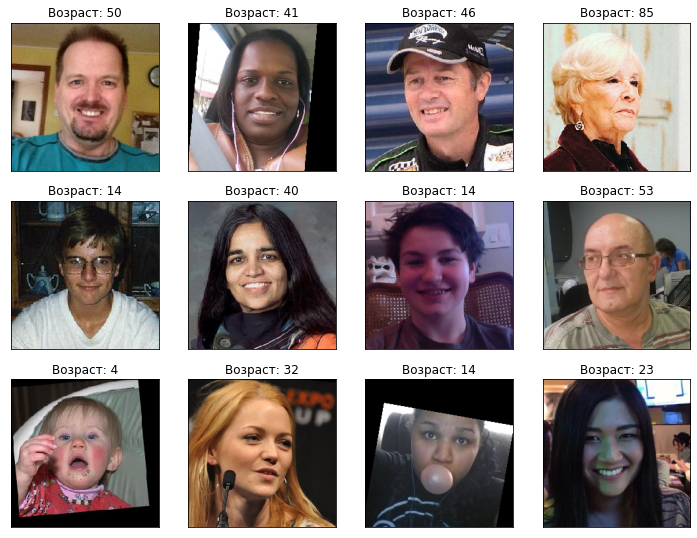

In [9]:
fig = plt.figure(figsize=(10, 10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Вывод:** 
* Фотографии предобработаны: можно увидеть, что некоторые фотографии были сдвинуты и повёрнуты так, чтобы лицо было посередине изображения. Применять аугментацию не нужно.
* По графику распределения можно увидеть, что большинство людей на фотографиях в возрасте от 20 до 30 лет. Также на графике есть аномалии около 0 и 50 лет. 


## Обучение модели

```python
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
 
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
 
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
2023-03-31 13:30:12.900674: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-31 13:30:15.213806: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 72s - loss: 221.8920 - mae: 10.7482 - val_loss: 703.7538 - val_mae: 21.5798
Epoch 2/5
178/178 - 38s - loss: 60.6062 - mae: 5.8799 - val_loss: 711.1992 - val_mae: 21.6666
Epoch 3/5
178/178 - 38s - loss: 29.8379 - mae: 4.1885 - val_loss: 286.0353 - val_mae: 12.4554
Epoch 4/5
178/178 - 38s - loss: 18.8006 - mae: 3.3401 - val_loss: 125.5236 - val_mae: 8.2903
Epoch 5/5
178/178 - 37s - loss: 14.4970 - mae: 2.8900 - val_loss: 97.7519 - val_mae: 7.4786
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 97.7519 - mae: 7.4786
Test MAE: 7.4786 
```

## Анализ обученной модели

**Вывод:** Для обучения была использована нейросеть ResNet. С алгоритмом оптимизации Adam. В результате обучения MAE равна 7.4786. Следовательно модель достигла требуемого значения.